# Introduction to testing code for data science

## Topic learning objectives

By the end of this topic, students should be able to:

1. Fully specify a function and write comprehensive tests against the specification.
2. Reproducibly generate test data (e.g., data frames, models, plots).
3. Discuss the observability of unit outputs in data science (e.g., plot objects), and how
this should be taken into account when designing software.
4. Explain why test-driven development (TDD) affords testability
5. Use exceptions when writing code.
6. Test if a function is throwing an exception when it should, and that is does not do so
when it shouldn’t.
7. Evaluate test suite quality.

In [1]:
# Limit output of data frame output to 10 lines
options(repr.matrix.max.rows = 10)

## Functions

- Functions are individual units of code that perform a specific task.
- They are useful for increasing code modularity - this helps with reusability and readability.
- Functions can be easily tested to ensure the correct function outputs are given and that they handle user errors in expected ways. These checks help to increase the robustness of your code.

When should you write a function? In practice, when you start re-writing code for the second or third time, it really is time to abstract your code into a function. When does this happen in data science? Think back to your DSCI 100 projects, you may have had redundant code when you:

1. Repeatedly applied some data cleaning/manipulation to columns in your raw data suring the data wrangling process

2. Created many similar data visualizations during your exploratory data analysis

3. Created many similar tidymodels workflows when you were tuning your predictive models


## Defining functions in R:

In this course, we will get to practice writing functions (and then testing them) in the R programming language. Given this has not been covered in the course pre-requisites, we will cover it here briefly. To learn more about functions in R, we refer you to the [functions chapter in the Advanced R book](https://adv-r.hadley.nz/functions.html).

- Use `variable <- function(…arguments…) { …body… }` to create a function and give it a name

Example:

In [2]:
add_two_numbers <- function(x, y) {
  x + y
}

add_two_numbers(1, 4)

[1] 5

- Functions in R are objects. This is referred to as “first-class functions”.
- The last line of the function returns the object created, or listed there. To return a value early use the special word `return` (as shown below).

In [3]:
math_two_numbers <- function(x, y, operation) {
  if (operation == "add") {
    return(x + y)
  } 
  x - y
}

In [4]:
math_two_numbers (1, 4, "add")

[1] 5

In [5]:
math_two_numbers (1, 4, "subtract")

[1] -3

### Default function arguments

Default values can be specified in the function definition:

In [6]:
math_two_numbers <- function(x, y, operation = "add") {
  if (operation == "add") {
    return(x + y)
  } 
  x - y
}

In [7]:
math_two_numbers (1, 4)

[1] 5

In [8]:
math_two_numbers (1, 4, "subtract")

[1] -3

#### Optional - Advanced

##### Extra arguments via `...`

If we want our function to be able to take extra arguments that we don't specify, we must explicitly convert `...` to a list (otherwise `...` will just return the first object passed to `...`):

In [9]:
add <- function(x, y, ...) {
    print(list(...))
}
add(1, 3, 5, 6)

[[1]]
[1] 5

[[2]]
[1] 6



### Lexical scoping in R

R’s lexical scoping follows several rules, we will cover the following 3:

- Name masking
- Dynamic lookup
- A fresh start

#### Name masking

Object names which are defined inside a function mask object names defined outside of that function. For example, below `x` is first defined in the global environment, and then also defined in the function environment. `x` in the function environment masks `x` in the global environment, so the value of 5 is used in `to_add + x` instead of 10:

In [10]:
x <- 10

add_to_x <- function(to_add) {
    x <- 5
    to_add + x
}

add_to_x(2)

[1] 7

If a function refers to an object name that is not defined inside the function, then R looks at the environment one level above. And if it is not found there, it again, looks another level above. This will happen all the way up the environment tree until it searches all possible environments for that session (including the global environment and loaded packages).

<img src="img/env-lookup.png" width=600>

*__Attribution__: Derived from [Advanced R](https://adv-r.hadley.nz/) by Hadley Wickham*

Here `x` is not defined in the function environment, and so R then looks one-level up to the global environment to try to find `x`. In this case it does and it is then used to calculate `to_add + x`:

In [11]:
x <- 10

add_to_x <- function(to_add) {
    to_add + x
}

add_to_x(2)

[1] 12

#### Dynamic lookup

R does not look up the values for objects it references when it is defined/created, instead it does this when the function is called. This can lead to the function returning different things depending on the values of the objects it references outside of the function's environment. 

For example, each time the function `add_to_x` is run, R looks up the current value of `x` and uses that to compute `to_add + x`:

In [12]:
add_to_x <- function(to_add) {
    to_add + x
}

x <- 10
add_to_x(2)

x <- 20
add_to_x(2)

[1] 12

[1] 22

#### A fresh start

Functions in R have no memory of what happened the last time they were called. This happens because a new function environment is created, R created a new environment in which to execute it. 

For example, even though we update the value of `x` inside the function by adding two to it every time we execute it, it returns the same value each time, because R creates a new function environment each time we run it and that environment has no recollection of what happened the last time the function was run:

In [13]:
x <- 10

add_to_x <- function(to_add) {
    x <- to_add + x
    x
}

add_to_x(2)
add_to_x(2)
add_to_x(2)

[1] 12

[1] 12

[1] 12

### Lazy evaluation

In R, function arguments are lazily evaluated: they’re only evaluated if accessed.



Knowing that, now consider the `add_one` function written in both R and Python below:

```
# R code (this would work)
add_one <- function(x, y) {
    x <- x + 1
    return(x)
} 
```

```
# Python code (this would not work)
def add_one(x, y):
    x = x + 1
    return x
```

Why will the above `add_one` function will work in R, but the equivalent version of the function in python would break?

- Python evaluates the function arguments before it evaluates the function and because it doesn't know what `y` is, it will break even though it is not used in the function.
- R performs lazy evaluation, meaning it delays the evaluation of the function arguments until its value is needed within/inside the function. Since `y` is never referenced inside the function, R doesn't complain, or even notice it.


#### `add_one` in R

```
add_one <- function(x, y) {
    x <- x + 1
    return(x)
} 
```

This works: 


```
add_one(2, 1)
```

```
3
```

and so does this:


```
add_one(2)
```

```
3
```

#### `add_one` in Python

```
def add_one(x, y):
    x = x + 1
    return x`
```

This works: 


```
add_one(2, 1)
```

```
3
```

This does not:


```
add_one(2)
```

```
---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
<ipython-input-5-f2e542671748> in <module>
----> 1 add_one(2)

TypeError: add_one() missing 1 required positional argument: 'y'
```

#### The power of lazy evaluation

Let's you have easy to use interactive code like this:

In [14]:
dplyr::select(mtcars, mpg, cyl, hp, qsec)

,mpg,cyl,hp,qsec
,<dbl>,<dbl>,<dbl>,<dbl>
Mazda RX4,21.0,6,110,16.46
Mazda RX4 Wag,21.0,6,110,17.02
Datsun 710,22.8,4,93,18.61
Hornet 4 Drive,21.4,6,110,19.44
Hornet Sportabout,18.7,8,175,17.02
⋮,⋮,⋮,⋮,⋮
Lotus Europa,30.4,4,113,16.9
Ford Pantera L,15.8,8,264,14.5
Ferrari Dino,19.7,6,175,15.5


Notes: 
- There's more than just lazy evaluation happening in the code above, but lazy evaluation is part of it.
- `package::function()` is a way to use a function from an R package without loading the entire library.


## Exception handling

Sometimes our code is correct but we still encounter errors. This commonly occurs with functions when users attempt to use them in weird and creative ways that the developer did not intend. Developers are well advised to try to anticipate some of this user behaviour and guard against this in a way that can be of help to the user. One way to do this is to have a function fail intentionally when incorrect user input is given. 

Imagine we have a simple function to convert temperatures from Fahrenheit to Celsius:

In [15]:
fahr_to_celsius <- function(temp) {
  (temp - 32) * 5/9
}

What if our user anticipates that our function can handle numbers written as strings? When this happens our users gets a somewhat cryptic error message (which is inversely correlated with their knowledge of the R programming language):

```
fahr_to_celsius("thirty")
```

```
Error in temp - 32: non-numeric argument to binary operator
Traceback:

1. fahr_to_celsius("thirty")
```

This error message is not as helpful as it could be! Also, if this calculation happened to take a long time, it might be nicer to check the data type before we attempt the calculation and then if the wrong data type was given, throw an purposeful error with a more helpful error message. One way we can do this simply in R is using a conditional (i.e., `if` statement) to test the type and then calling `stop` with a useful error message if the type is incorrect. 

For example with the `fahr_to_celsius` function, we can use `if(!is.numeric(temp))` to check whether `temp` is not numeric. And then if it is not, `stop` causes a break and the printing out of the more helpful error message "`fahr_to_celsius` expects a vector of numeric values

In [16]:
fahr_to_celsius <- function(temp) {
  if(!is.numeric(temp)) {    
    stop("`fahr_to_celsius` expects a vector of numeric values")
  }
  (temp - 32) * 5/9
}

```
fahr_to_celsius("thirty")
```

```
Error in fahr_to_celsius("thirty"): `fahr_to_celsius` expects a vector of numeric values
Traceback:

1. fahr_to_celsius("thirty")
2. stop("`fahr_to_celsius` expects a vector of numeric values")   # at line 3 of file <text>
```

If you wanted to issue a warning instead of an error, you could use `warning` in place of `stop` in the example above. However, in most cases it is better practice to throw an error than to print a warning...

More advanced exception handling exists in R, and I invite interested learner to read more about it here in the [Condition Handling](http://adv-r.had.co.nz/Exceptions-Debugging.html#condition-handling) and [Defensive Programming](http://adv-r.had.co.nz/Exceptions-Debugging.html#defensive-programming) sections of Advanced R.

## Programming with the `tidyverse` functions

The functions from the `tidyverse` are beautiful to use interactively - with these functions, we can "pretend" that the data frame column names are objects in the global environment and refer to them without quotations (e.g., `""`)

In [17]:
library(tidyverse)
library(gapminder)

gapminder |>
  filter(country == "Canada", year == 1952)

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──



✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1



── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



country,continent,year,lifeExp,pop,gdpPercap
<fct>,<fct>,<int>,<dbl>,<int>,<dbl>
Canada,Americas,1952,68.75,14785584,11367.16


expecially when compared with base R:

In [18]:
gapminder[gapminder$country == "Canada" & gapminder$year == 1952, ]

country,continent,year,lifeExp,pop,gdpPercap
<fct>,<fct>,<int>,<dbl>,<int>,<dbl>
Canada,Americas,1952,68.75,14785584,11367.16


However, the beauty of being able to refer to data frame column names in R without quotations, leads to problems when we try to use them in a function. 
For example, 

```
filter_gap <- function(col, val) {
    filter(gapminder, col == val)
}

filter_gap(country, "Canada")
```

```
Error: object 'country' not found
Traceback:

1. filter_gap(country, "Canada")
2. filter(gapminder, col == val)   # at line 4 of file <text>
3. filter.tbl_df(gapminder, col == val)
4. filter_impl(.data, quo)

```

Why does `filter` work with non-quoted variable names, but our function `filter_gap` fail?
At a very high-level, this is because `filter` is doing more behind the scenes to handle these
unquoted column names than we see without looking at the source code. 
So to make this work for our function, we need to do a little more work too.

Given that this is not a course in R programming, we will not go into the details of why this happens,
but we will show one way of how to handle this. 
For learners intersted to learn more about why this happens,
we recommend reading these two resources:

1. [Programming with `dplyr`](https://dplyr.tidyverse.org/articles/programming.html)
2. [Metaprogramming](https://adv-r.hadley.nz/metaprogramming.html)

### Defining `tidyverse` functions by embracing column names: `{{ }}`

In the newest release of the `rlang` R package, there has been the introduction of the `{{` (pronounced "curly curly") operator.
This operator does the necessary work behind the scenes so that you can continue to use unquoted column names 
with the `tidyverse` functions even when you use them in functions that you write yourself. 

To use the `{{` operator, we "embrace" the unquoted column names when we refer to them inside our function body.
An important note is that there are several ways to implement the usage of unquoted column names in R,
and  the `{{` operator only works with the `tidyverse` functions.
Please refer to the [Metaprogramming](https://adv-r.hadley.nz/metaprogramming.html) chapter of Advanced R 
if you need to do this with non-tidyverse functions.

Here's the function we show above working when we use the `{{` operator to "embrace" the unquoted column names:

In [19]:
filter_gap <- function(col, val) {
  filter(gapminder, {{col}} == val)
}

In [20]:
filter_gap(country, "Canada")

country,continent,year,lifeExp,pop,gdpPercap
<fct>,<fct>,<int>,<dbl>,<int>,<dbl>
Canada,Americas,1952,68.75,14785584,11367.16
Canada,Americas,1957,69.96,17010154,12489.95
Canada,Americas,1962,71.30,18985849,13462.49
Canada,Americas,1967,72.13,20819767,16076.59
Canada,Americas,1972,72.88,22284500,18970.57
⋮,⋮,⋮,⋮,⋮,⋮
Canada,Americas,1987,76.860,26549700,26626.52
Canada,Americas,1992,77.950,28523502,26342.88
Canada,Americas,1997,78.610,30305843,28954.93


### The walrus operator `:=` is needed when assigning values
For similar reasons, the walrus operator (`:=`) is needed when writing functions that create new columns using unquoted column names with the `tidyverse` functions:

In [21]:
group_summary <- function(data, group, col, fun) {
  data |>
    group_by({{ group }}) |>
    summarise( {{ col }} := fun({{ col }}))
}

In [22]:
group_summary(gapminder, continent, gdpPercap, mean)

continent,gdpPercap
<fct>,<dbl>
Africa,2193.755
Americas,7136.110
Asia,7902.150
Europe,14469.476
Oceania,18621.609


## Function documentation

Function documentation is extremely useful at both the time of function creation/development, as well as at the time of function usage by the user. At the time of creation/development, it is useful for clearly delineating and communication the planned function's specifications. At the time of usage, it is often the primary documentation a user will refer to in order to understand how to use the function. If a function is not well documented, it will not be well understood or widely used.

### Function documentation in R

In R, we write function documentation in a style that the [`roxygen2` R package](https://roxygen2.r-lib.org/) can use to automatically generate nicely formatted documentation, accessible via R's help function, when we create R packages. This is not available to us until we package our functions in software packages, however it is a good practice to get into because it helps ensure you document the key aspects of a function for your user, and it means that when you go to create an R package to share your function, you will have already correctly formatted the function documentation - saving future you some work!

In [23]:
#' Converts temperatures from Fahrenheit to Celsius.
#'    
#' @param temp a vector of temperatures in Fahrenheit
#' 
#' @return a vector of temperatures in Celsius
#' 
#' @examples
#' fahr_to_celcius(-20)
fahr_to_celsius <- function(temp) {
    (temp - 32) * 5/9
}

RStudio has a nice feature to provide a `roxygen2` formatted skeleton for function documentation. To use it, you put the cursor in the function definition, and then select the menu items "Code" > "Insert Roxygen Skeleton":

<img src="img/insert_roxygen.png" width=600>

## Practice writing functions in R

To practice writing functions in R, you can attempt this worksheet: https://github.com/UBC-DSCI/dsci-310-student/blob/main/practice/worksheet_functions_in_r.ipynb

*Note: to access the automated software tests for feedback on your answers, you will want to clone or download [this GitHub repo](https://github.com/UBC-DSCI/dsci-310-student) and navigate to the `practice` directory.*

## Testing code for data science

Now that we know how to write functions in R, we will learn how to write tests for them to make them more robust.
As well as how writing tests can actually help us write our functions in the first place!

## Workflow for writing functions and tests for data science

How should we get started writing functions and tests for data science? There are many ways one could proceed, however some paths will be more efficient and less error-prone, and more robust than others. Borrowing from software development best practices, one recommended workflow is shown below:

1. **Write the function specifications and documentation - but do not implement the function.** This means that you will have an empty function, that specifies and documents what the name of the function is, what arguments it takes, and what it returns. 

2. **Plan the test cases and document them.** Your tests should assess whether the function works as expected when given correct inputs, as well as that it behaves as expected when given incorrect inputs (e.g., throws an error when the wrong type is given for an argument). For the cases of correct inputs, you will want to test the top, middle and bottom range of these, as well as all possible combinations of argument inputs possible. Also, the test data should be as simple and tractable as possible while still being able to assess your function.

3. **Create test data that is useful for assessing whether your function works as expected.** In data science, you likely need to create both the data that you would provide as inputs to your function, as well as the data that you would expect your function to return.

4. **Write the tests to evaluate your function based on the planned test cases and test data.** 

5. **Implement the function by writing the needed code in the function body to pass the tests.**

6. **Iterate between steps 2-5 to improve the test coverage and function.**

### Example of workflow for writing functions and tests for data science



Let's say we want to write a function for a task we repeatedly are performing in our data analysis. For example, summarizing the number of observations in each class. This is a common task performed for almost every classification problem to examine how many classes there are to understand if we are facing a binary or multi-class classification problem, as well as to examine whether there are any class imbalances that we may need to deal with before tuning our models.

##### 1. Write the function specifications and documentation - but do not implement the function:
The first thing we should do is write the function specifications and documentation. This can effectively represented by an empty function and `roxygen2`-styled documentation in R as shown below:

In [24]:
#' Count class observations
#'
#' Creates a new data frame with two columns, 
#' listing the classes present in the input data frame,
#' and the number of observations for each class.
#'
#' @param data_frame A data frame or data frame extension (e.g. a tibble).
#' @param class_col unquoted column name of column containing class labels
#'
#' @return A data frame with two columns. 
#'   The first column (named class) lists the classes from the input data frame.
#'   The second column (named count) lists the number of observations for each class from the input data frame.
#'   It will have one row for each class present in input data frame.
#'
#' @export
#'
#' @examples
#' count_classes(mtcars, am)
count_classes <- function(data_frame, class_col) {
  # returns a data frame with two columns: class and count
}

##### 2. Plan the test cases and document them:

Next, we should plan out our test cases and start to document them. At this point we can sketch out a skeleton for our test cases with code but we are not yet ready to write them, as we first will need to reproducibly create test data that is useful for assessing whether your function works as expected. So considering our function specifications, some kinds of input we might anticipate our function may receive, and correspondingly what it should return is listed in a table below:

| Type of input |Function input | Function should return |
|---------------|---------------|------------------------|
| Correct user input | Data frame with five classes, with 3 observations per class, and an unquoted column name of column containing class labels. | A new data frame with two columns and five rows. One column with the class names, and one with the counts of 3 observations for each class. |
| Correct user input | Data frame with two classes, with 3 observations per class, and an unquoted column name of column containing class labels. | A new data frame with two columns and two rows. One column with the class names, and one with the counts of 3 for each class. |
| Correct user input | Data frame with two classes, with 3 observations for one class, 2 observations for another, and an unquoted column name of column containing class labels. | A new data frame with two columns and two rows. One column with the class names, and one with the counts of 3 for one class and 2 for the other class. |
| Correct user input | Data frame with one class, with 3 observations per class, and an unquoted column name of column containing class labels. | A new data frame with two columns and one row. One column with the class names, and one with the counts of 3 observations for each class. |
| Correct user input | Data frame with two classes, with multiple observations for one class, and a single observation for the other class. Also an unquoted column name of column containing class labels. | A new data frame with two columns and two rows. One column with the class names, and one with the counts of observations for each class. |
| Correct user input | An empty data frame with no classes, and no observations per class. Also an unquoted column name of column containing class labels. | A new empty data frame with two columns and 0 rows. One column with the class names, and one with the counts of observations for each class. |
| Incorrect user input | Data frame with two classes, with multiple observations per class and a vector of class labels as a separate object | An error that reports the value for the `class_col` argument should be an unquoted column name of column containing class labels from the data frame given in to the first argument. |
| Incorrect user input | A list as the value for the argument to `data_frame`, and the name of one of the list elements as the value for the argument `class_col` | An error that reports the value for the the `data_frame` object should be a data frame or data frame extension (e.g. a tibble) |

Next, I sketch out a skeleton for the unit tests. For R, we will use the well maintained and popular `testthat` R package for writing our tests. For extra resources on `testthat` beyond what is demonstrated here, we recommend reading:
- [`testthat` documentation](https://testthat.r-lib.org/)
- [Testing chapter of the R packages book](https://r-pkgs.org/tests.html)

With `testthat` we create a `test_that` statement for each related group of tests for a function. For our example, we will create the four `test_that` statements shown below:

In [25]:
library(testthat)


Attaching package: ‘testthat’




The following object is masked from ‘package:dplyr’:

    matches




The following object is masked from ‘package:purrr’:

    is_null




The following objects are masked from ‘package:readr’:

    edition_get, local_edition




The following object is masked from ‘package:tidyr’:

    matches




In [26]:
test_that("`count_classes` should return a data frame or data frame extension", {
  # tests to be added here
})

test_that("`count_classes` should return a data frame, or data frame extension, 
with the number of rows that corresponds to the number of unique classes 
in the column passed to `class_col`", {
  # tests to be added here
})

test_that("`count_classes` should return a data frame, or data frame extension, 
whose values in the `count` column correspond to the number of observations 
for the group in the `class` column from the original data frame", {
  # tests to be added here
})

test_that("`count_classes` should throw an error when incorrect types 
are passed to `data_frame` and `class_col` arguments", {
  # tests to be added here
})

── Skip (???): `count_classes` should return a data frame or data frame extension ─────────────────────
Reason: empty test



── Skip (???): `count_classes` should return a data frame, or data frame extension, 
with the number of rows that corresponds to the number of unique classes 
in the column passed to `class_col` ─────────────────────
Reason: empty test



── Skip (???): `count_classes` should return a data frame, or data frame extension, 
whose values in the `count` column correspond to the number of observations 
for the group in the `class` column from the original data frame ─────────────────────
Reason: empty test



── Skip (???): `count_classes` should throw an error when incorrect types 
are passed to `data_frame` and `class_col` arguments ─────────────────────
Reason: empty test



##### 3. Create test data that is useful for assessing whether your function works as expected:

Now that we have a plan, we can create reproducible test data for that plan! 
When we do this, we want to keep our data as small and tractable as possible. 
We want to test things we know the answer to, or can at a minimum calculate by hand.
We will use R code to reproducibly create the test data. 
We will need to do this for the data we will feed in as inputs to our function in the tests, 
as well as the data we expect our function to return.

In [27]:
# function input for tests
five_classes_3_obs <- data.frame(class_lables = rep(c("class1", "class2", "class3", "class4", "class5"), 3))
two_classes_3_obs <- data.frame(class_lables = rep(c("class1", "class2"), 3))
two_classes_3_and_2_obs <- data.frame(class_lables = c(rep(c("class1", "class2"), 2), "class1"))
two_classes_3_and_1_obs <- data.frame(class_lables = c(rep("class1", 3), "class2"))
one_class_3_obs <- data.frame(class_lables = rep("class1", 3))
empty_df  <- data.frame(class_lables = character(0))
vector_class_labels <- rep(c("class1", "class2"), 3)
two_classes_3_obs_as_list <- list(class_lables = rep(c("class1", "class2"), 3))

# expected function output
five_classes_3_obs_output <- data.frame(class = c("class1", "class2", "class3", "class4", "class5"),
                                        count = rep(3, 5))
two_classes_3_obs_output <- data.frame(class = c("class1", "class2"),
                                count = c(3, 3))
two_classes_3_and_2_obs_output <- data.frame(class = c("class1", "class2"),
                                      count = c(3, 2))
two_classes_3_and_1_obs_output <- data.frame(class = c("class1", "class2"),
                                      count = c(3, 1))
one_class_3_obs_output <- data.frame(class = "class1",
                              count = 3)
empty_df_output <- data.frame(class = character(0),
                              count = numeric(0))

##### 4. Write the tests to evaluate your function based on the planned test cases and test data:

Now that we have the skeletons for our tests, and our reproducible test data, we can actually write the internals for our tests! We will do this by using `expect_*` functions from the `testthat` package. The table below shows some of the most commonly used `expect_*` functions. However, there are many more that can be found in the [`testthat` expectations reference documentation](https://testthat.r-lib.org/reference/index.html#expectations).

###### `testthat` test structure:

```
test_that("Message to print if test fails", expect_*(...))
```

##### Common `expect_*` statements for use with `test_that`

###### Is the object equal to a value? 
- `expect_identical` - test two objects for being exactly equal
- `expect_equal` - compare R objects x and y testing ‘near equality’ (can set a tolerance)
- `expect_equivalent` - compare R objects x and y testing ‘near equality’ (can set a tolerance) and does not assess attributes

###### Does code produce an output/message/warning/error?
- `expect_error` - tests if an expression throws an error
- `expect_warning` - tests whether an expression outputs a warning
- `expect_output` - tests that print output matches a specified value

###### Is the object true/false?

These are fall-back expectations that you can use when none of the other more specific expectations apply. The disadvantage is that you may get a less informative error message.

- `expect_true` - tests if the object returns `TRUE`
- `expect_false` - tests if the object returns `FALSE`

In [28]:
test_that("`count_classes` should return a tibble", {
  expect_s3_class(count_classes(two_classes_3_obs, class_lables), "tibble")
})

test_that("`count_classes` should return a data frame, or data frame extension, 
with the number of rows that corresponds to the number of unique classes 
in the column passed to `class_col`", {
  expect_equivalent(count_classes(five_classes_3_obs, class_lables), five_classes_3_obs_output)
  expect_equivalent(count_classes(two_classes_3_obs, class_lables), two_classes_3_obs_output)
  expect_equivalent(count_classes(one_class_3_obs, class_lables), one_class_3_obs_output)
  expect_equivalent(count_classes(empty_df, class_lables), empty_df_output)
})

test_that("`count_classes` should return a data frame, or data frame extension, 
whose values in the `count` column correspond to the number of observations 
for the group in the `class` column from the original data frame", {
  expect_equivalent(count_classes(two_classes_3_and_2_obs, class_lables), two_classes_3_and_2_obs_output)
  expect_equivalent(count_classes(two_classes_3_and_1_obs, class_lables), two_classes_3_and_1_obs_output)
})

test_that("`count_classes` should throw an error when incorrect types 
are passed to `data_frame` and `class_col` arguments", {
  expect_error(count_classes(two_classes_3_obs, vector_class_labels))
  expect_error(count_classes(two_classes_3_obs_as_list, class_lables))
})

── Failure (<text>:2:3): `count_classes` should return a tibble ─────────────────────
count_classes(two_classes_3_obs, class_lables) is not an S3 object



ERROR: [1m[33mError[39m:[22m
[33m![39m Test failed


Wait what??? Most of our tests fail...

Yes, we expect that, we haven't written our function body yet!

#### 5. Implement the function by writing the needed code in the function body to pass the tests:

FINALLY!! We can write the function body for our function! And then call our tests to see if they pass!

In [29]:
#' Count class observations
#'
#' Creates a new data frame with two columns, 
#' listing the classes present in the input data frame,
#' and the number of observations for each class.
#'
#' @param data_frame A data frame or data frame extension (e.g. a tibble).
#' @param class_col unquoted column name of column containing class labels
#'
#' @return A data frame with two columns. 
#'   The first column (named class) lists the classes from the input data frame.
#'   The second column (named count) lists the number of observations for each class from the input data frame.
#'   It will have one row for each class present in input data frame.
#'
#' @export
#'
#' @examples
#' count_classes(mtcars, am)
count_classes <- function(data_frame, class_col) {
  if (!is.data.frame(data_frame)) {
    stop("`data_frame` should be a data frame or data frame extension (e.g. a tibble)")
  }

  data_frame |>
    dplyr::group_by({{ class_col }}) |>
    dplyr::summarize(count = dplyr::n()) |>
    dplyr::rename_at(1, ~ "class")
}

> Note 1: we recommending using the syntax `PACKAGE_NAME::FUNCTION()` when writing functions that will be sourced into other files in R to make it explicitly clear what external packages they depend on. This becomes even more important when we create R packages from our functions later. 
>
> Note 2: `group_by` will throw a fairly useful error message of `class_col` is not found in `data_frame`, and we we can let `group_by` handle that error case instead of writing our own exception to throw an error on.

In [30]:
test_that("`count_classes` should return a tibble", {
  expect_s3_class(count_classes(two_classes_3_obs, class_lables), "data.frame")
})

test_that("`count_classes` should return a data frame, or data frame extension, 
with the number of rows that corresponds to the number of unique classes 
in the column passed to `class_col`", {
  expect_equivalent(count_classes(five_classes_3_obs, class_lables), five_classes_3_obs_output)
  expect_equivalent(count_classes(two_classes_3_obs, class_lables), two_classes_3_obs_output)
  expect_equivalent(count_classes(one_class_3_obs, class_lables), one_class_3_obs_output)
  expect_equivalent(count_classes(empty_df, class_lables), empty_df_output)
})

test_that("`count_classes` should return a data frame, or data frame extension, 
whose values in the `count` column correspond to the number of observations 
for the group in the `class` column from the original data frame", {
  expect_equivalent(count_classes(two_classes_3_and_2_obs, class_lables), two_classes_3_and_2_obs_output)
  expect_equivalent(count_classes(two_classes_3_and_1_obs, class_lables), two_classes_3_and_1_obs_output)
})

test_that("`count_classes` should throw an error when incorrect types 
are passed to `data_frame` and `class_col` arguments", {
  expect_error(count_classes(two_classes_3_obs, vector_class_labels))
  expect_error(count_classes(two_classes_3_obs_as_list, class_lables))
})

Test passed 🎊
Test passed 🌈
Test passed 🥇
Test passed 🎉


No message from the test, means the tests passed!

<img src="https://media.giphy.com/media/EXFAJtutz5Ig8/giphy.gif" >

Are we done? For the purposes of this demo, yes! **However in practice you would usually cycle through steps 2-5 two-three more times to further improve our tests and and function!**

### Where do the function and test files go?

In the workflow above, 
we skipped over where we should put our functions we will use in our data analyses,
as well as where we put the tests for our function, and how we call those tests!

We summarize the answer to these questions below, 
but **highly recommend you explore and test out our demonstration GitHub repository 
that has a minimal working example of this: <https://github.com/ttimbers/demo-tests-ds-analysis>**

#### Where does the function go?

In R, functions should be abstracted to R scripts (plain text files that end in `.R`)
which live in the project's `R` directory. 
Commonly we name the R script with the same name as the function 
(however, we might choose a more general name if the R script contains many functions).

In the analysis file where we call the function (e.g. `eda.ipynb`) 
we need to call `source("PATH_TO_FILE_CONTAINING_FUNCTION")`
before we are able to use the function(s) contained in that R script inside our analysis file.

#### Where do the tests go?

The tests for the function should live in `tests/testthat/test-FUNCTION_NAME.R`,
and the code to reproducibly generate helper data for the tests 
lives in `tests/testthat/helper-FUNCTION_NAME.R`.
The test suite can be run via `testthat::test_dir("tests/testthat")`.
`testthat::test_dir("tests/testthat")` first runs any files that begin with `helper*` 
and then any files that begin with `test*`.

#### Convenience functions for setting this up

Several [`usethis` R package](https://usethis.r-lib.org/index.html) functions can be used to setup the file 
and directory structure needed for this:
- `usethis::use_r("FUNCTION_NAME")` can be used to create the R script file the function should live in, inside the R directory
- `usethis::use_testthat()` can be used to create the necessary test directories to use `testthat`'s automated test suite execution function (`testthat::test_dir("tests/testthat")`)
- `usethis::use_test("FUNCTION_NAME")` can be used to create the test file for each function

*Note: `tests/testthat/helper-FUNCTION_NAME.R` needs to be created manually, as there is no `usethis` function to automate this.*

## Reproducibly generating test data

As highlighted above, where at all possible,
we should use code to generate reproducible, simple 
and tractable helper data for our tests.
When using the `testthat` R package in R to automate the running of the test suite, 
the convention is to put such code in a file named `helper-FUNCTION_NAME.R`
which should live in the `tests/testthat` directory.

## Common types of test levels in data science

1. Unit tests - exercise individual components, usually methods or functions, in isolation. This kind of testing is usually quick to write and the tests incur low maintenance effort since they touch such small parts of the system. They typically ensure that the unit fulfills its contract making test failures more straightforward to understand. *This is the kind of tests we wrote for our example for `count_classes` above.*

2. Integration tests -  exercise groups of components to ensure that their contained units interact correctly together. Integration tests touch much larger pieces of the system and are more prone to spurious failure. Since these tests validate many different units in concert, identifying the root-cause of a specific failure can be difficult. *In data science, this might be testing whether several functions that call each other, or run in sequence, work as expected (e.g., tests for a `tidymodel`'s `workflow` function)*

*Source: [CPSC 310 class notes from Reid Holmes, UBC](https://github.com/ubccpsc/310/blob/master/resources/readings/Testing.md)*

## Test-driven development (TDD) and testability

**Test-driven development (TDD):** a process for developing software, whereby you write test cases that assess the software requirements before you write the software that implements the software requirements/functionality. *Hey! We just did that in the workflow above!*

*Source: [Wikipedia](https://en.wikipedia.org/wiki/Main_Page)*

**Testability** is defined as the degree to which a system or component facilitates the establishment of test objectives
and the execution of tests to determine whether those objectives have been achieved.

In order to be successful, a test needs to be able to execute the code you wish to test, in a way that can trigger a defect that will propagate an incorrect result to a program point where it can be checked against the expected behaviour. From this we can derive four high-level properties required for effective test writing and execution. These are controllability, observability, isolateablilty, and automatability.

- **controllability**: the code under test needs to be able to be programmatically controlled
- **observability**: the outcome of the code under test needs to be able to be verified
- **isolateablilty**: the code under test needs to be able to be validated on its own
- **automatability**: the tests should be able to be executed automatically

*Source: [CPSC 310](https://github.com/ubccpsc/310/blob/master/resources/readings/TestabilityAssertions.md) & [CPSC 410](https://www.cs.ubc.ca/~rtholmes/teaching/2015t1/cpsc410/slides/410_19_testability.pdf) class notes from Reid Holmes, UBC]*

**Discussion:** Does test-driven development afford testability? How might it do so? Let's discuss controllability, observability, isolateablilty, and automatability in our case study of test-driven development of `count_classes`.

## Observability of unit outputs in data science

**Observability** is defined as the extent to which the response of the code under test (here our functions) to a test can be verified.

Questions we should ask when trying to understand how observable our tests are:
- What do we have to do to identify pass/fail?
- How expensive is it to do this?
- Can we extract the result from the code under test?
- Do we know enough to identify pass/fail?

*Source: [CPSC 410 class notes from Reid Holmes, UBC](https://www.cs.ubc.ca/~rtholmes/teaching/2015t1/cpsc410/slides/410_19_testability.pdf)*

These questions are easier to answer and address for code that creates simpler data science objects such as data frames, as in the example above. 
However, when our code under test does something more complex, such as create a plot object, these questions are harder to answer, or can be answered less fully...

Let's talk about how we might test code to create plots!

### Visual regression testing

When we use certain data visualization libraries, we might think that we can test all code that generates data visualizations similar to code that generates more traditional data objects, such as data frames. 

For example, when we create a scatter plot object with `ggplot2`, we can easily observe many of it's values and attributes. We show an example below:

In [43]:
options(repr.plot.width = 4, repr.plot.height = 4)

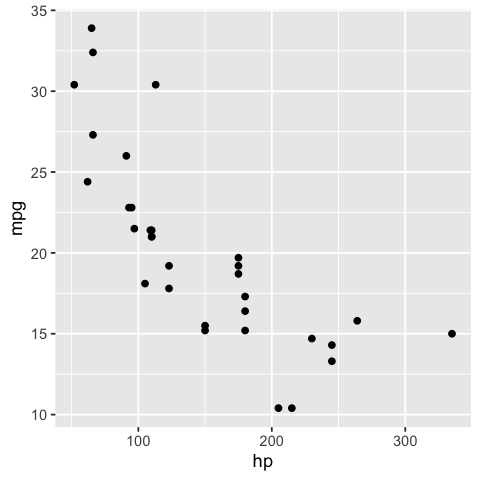

In [44]:
cars_ggplot_scatter <- ggplot2::ggplot(mtcars, ggplot2::aes(hp, mpg)) + 
    ggplot2::geom_point()

cars_ggplot_scatter

In [45]:
cars_ggplot_scatter$layers[[1]]$geom

<ggproto object: Class GeomPoint, Geom, gg>
    aesthetics: function
    default_aes: uneval
    draw_group: function
    draw_key: function
    draw_layer: function
    draw_panel: function
    extra_params: na.rm
    handle_na: function
    non_missing_aes: size shape colour
    optional_aes: 
    parameters: function
    required_aes: x y
    setup_data: function
    setup_params: function
    use_defaults: function
    super:  <ggproto object: Class Geom, gg>

In [46]:
cars_ggplot_scatter$mapping$x

<quosure>
expr: ^hp
env:  global

And so we could write some tests for a function that created a `ggplot2` object like so:

In [47]:
#' scatter2d 
#'
#' A short-cut function for creating 2 dimensional scatterplots via ggplot2.
#'
#' @param data data.frame or tibble
#' @param x unquoted column name to plot on the x-axis from data data.frame or tibble
#' @param y unquoted column name to plot on the y-axis from data data.frame or tibble
#'
#' @return
#' @export
#'
#' @examples
#' scatter2d(mtcars, hp, mpg)
scatter2d <- function(data, x, y) {
    ggplot2::ggplot(data, ggplot2::aes(x = {{x}}, y = {{y}})) +
        ggplot2::geom_point()
}

helper_data <- dplyr::tibble(x_vals = c(2, 4, 6),
                   y_vals = c(2, 4, 6))

helper_plot2d <- scatter2d(helper_data, x_vals, y_vals)

test_that('Plot should use geom_point and map x to x-axis, and y to y-axis.', {
    expect_true("GeomPoint" %in% c(class(helper_plot2d$layers[[1]]$geom)))
    expect_true("x_vals"  == rlang::get_expr(helper_plot2d$mapping$x))
    expect_true("y_vals" == rlang::get_expr(helper_plot2d$mapping$y))
})

Test passed 🥇


However, when we create a similar plot object using base R, we do not get an object back at all...

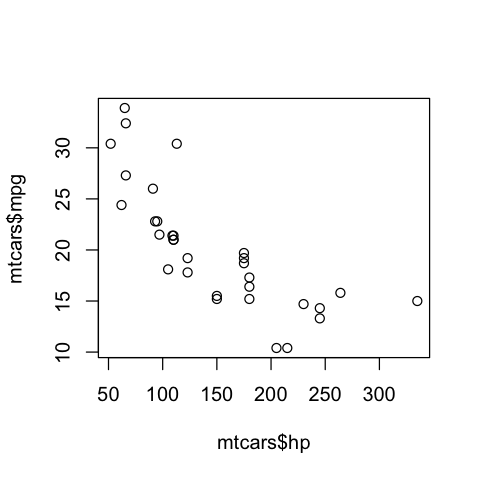

In [48]:
cars_scatter <- plot(mtcars$hp, mtcars$mpg)

In [49]:
typeof(cars_scatter)
class(cars_scatter)

[1] "NULL"

[1] "NULL"

So as you can see, testing plot objects can be more challenging. In the cases of several commonly used plotting functions and package in R and Python, the objects created are not rich objects with attributes that can be easily accessed (or accessed at all). Plotting packages like`ggplot2` (R) and `altair` (Python) which do create rich objects with observable values and attributes appear to be exceptions, rather than the rule. Thus, regression testing against an image generated by the plotting function is often the "best we can do", or because of this history, what is commonly done.

> **Regression testing** is defined as tests that check that recent changes to the code base do not break already implemented features.

Thus, once a desired plot is generated from the plotting function, visual regression tests can be used to ensure that further code refactoring does not change the plot function. Tools for this exist for R in the [`vdiffr`](https://vdiffr.r-lib.org/) package. Matplotlib uses visual regression testing as well, you can see the docs for examples of this [here](https://matplotlib.org/3.3.4/devel/testing.html#writing-an-image-comparison-test).

#### Visual regression testing with `vdiffr`

Say you have a function 
that creates a nicely formatted scatter plot using `ggplot2`, 
such as the one shown below:

Warning message:
“Removed 2 rows containing missing values (geom_point).”


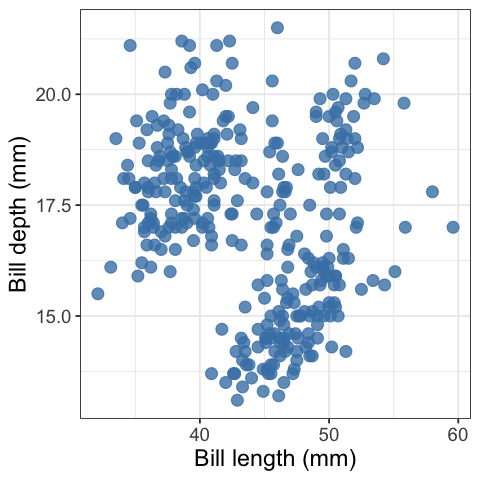

In [50]:
pretty_scatter <- function(.data, x_axis_col, y_axis_col) {
    ggplot2::ggplot(data = .data, 
                    ggplot2::aes(x = {{ x_axis_col }}, y = {{ y_axis_col }})) +
        ggplot2::geom_point(alpha = 0.8, colour = "steelblue", size = 3) +
        ggplot2::theme_bw() +
        ggplot2::theme(text = ggplot2::element_text(size = 14))
}

library(palmerpenguins)
library(ggplot2)
penguins_scatter <- pretty_scatter(penguins, bill_length_mm, bill_depth_mm) + 
    labs(x = "Bill length (mm)", y = "Bill depth (mm)")
penguins_scatter

> What is so pretty about this scatter plot? Compared to the default settings of a scatter plot created in `ggplot2` this scatter plot has a white instead of grey background, has blue points instead of black, has larger points, and they points have a bit of transparency so you can see some overlapping data points.

Now, say that you want to write tests to make sure that as you further develop 
and refactor your data visualization code, you do not break it or change the plot 
(because you have decided you are happy with what it looks like). 
You can use the [`vdiffr`](https://vdiffr.r-lib.org/) 
visual regression testing package to do this.
First, you need to abstract the function to an R script that lives in `R`.
For this case, we would create a file called `R/pretty_scatter.R` 
that houses the `pretty_scatter` function shown above.

Then you need to setup a `tests` directory 
and test file in which to house your tests 
that works with the [`testthat`](https://testthat.r-lib.org/) framework 
(we recommend using `usethis::use_testthat()` 
and `usethis::use_test("FUNCTION_NAME")` to do this).

Finally, add an expectation with `vdiffr::expect_doppelganger` to your 
`test_that` statement:

```r
library(palmerpenguins)
library(ggplot2)
library(vdiffr)
source("../../R/pretty_scatter.R")

penguins_scatter <- pretty_scatter(penguins, bill_length_mm, bill_depth_mm) + 
    labs(x = "Bill length (mm)", y = "Bill depth (mm)")
penguins_scatter

test_that("refactoring our code should not change our plot", {
    expect_doppelganger("pretty scatter", penguins_scatter)
})
```

Then when you run `testthat::test_dir("tests/testthat")` 
to run your test suite for the first time, 
it will take a snapshot of the figure created in your test for that visualization 
and save it to `tests/testthat/_snaps/EXPECT_DOPPELGANGER_TITLE.svg`.
Then as you refactor your code, you and run `testthat::test_dir("tests/testthat")` 
it will compare a new snapshot of the figure with the existing one.
If they differ, the tests will fail. 
You can then run `testthat::snapshot_review()` to get an interactive viewer 
which will let you compare the two data visualizations 
and allow you to either choose to accept the new snapshot 
(if you wish to include the changes to the data visualization 
as part of your code revision and refactoring)
or you can stop the app and revert/fix some of your code changes 
so that the data visualization is not unintentionally changed.

Below we show an example of running `testthat::snapshot_review()`
after we made our tests fail by removing `alpha = 0.8` from our `pretty_scatter`
function source:

<img src="img/snapshot-reviewer.png" width=600>

#### `vdiffr` demo

In this GitHub repository, we have created a `vdiffr` demo based on the case above: <https://github.com/ttimbers/vdiffr-demo>

To get experience and practice using this, we recommend forking this, and then cloning it so that you can try using this, and building off it locally.

##### Practice exercises

1. Inside RStudio, run `testthat::test_dir("tests/testthat")` to ensure you can get the tests to pass as they exist in the demo.

2. Change something about the code in `R/pretty_scatter.R` that will change what the plot looks like (text size, point colour, type of geom used, etc).

3. Run `testthat::test_dir("tests/testthat")` and see if the tests fail. If they do, run `testthat::snapshot_review()` to explore the differences in the two image snapshots. You may be prompted to install a couple R packages to get this working.

4. Add another plot function to the project and create a test for it using `testthat` and `vdiffr`.

## Evaluate test suite quality

We really want to know how well the code performs its expected tasks and how robustly it responds to unexpected inputs and situations. Answering this complex and qualitative question involves balancing tests value (e.g., protection against regressions and bugs introduced by refactoring) and tests cost (e.g., time for creation and upkeep, time to run the tests). This is hard to do, and takes a lot of time. Also, as hinted in the previous sentence, it is not very quantifiable.
    
Code coverage is a way to more simply assess code quality - it is useful to answer the question does the test suite validate all the code? This is an assessment that also attempts to be more quantitative and is popular because it can often be calculated automatically. However it does not factor time or test value, so we have to take it with a grain of salt.

*Source: [CPSC 310 class notes from Reid Holmes, UBC](https://github.com/ubccpsc/310/blob/master/resources/readings/WhiteBoxTesting.md)*

> ## Black box & white box testing
> 
> Up until now, we have primarily been focused on deriving tests when thinking about the code specifications - what is the functionality of the code, and does it do what we expect. For example, most of the tests we wrote for the `count_classes` function would fall under the guise of **black box testing**. After we follow our TDD-inspired workflow for writing functions and tests for data science, we may want to look inside our code and do some testing of how it is implemented. This would fall under the umbrella of **white box testing** and code coverage can be very helpful here to identify portions of code that is not being tested well, or at all.  
> 
>  **Black box testing:** is a method of software testing that examines the functionality of an application without peering into its internal structures or workings. This method of test can be applied virtually to every level of software testing: unit, integration, system and acceptance. It is sometimes referred to as specification-based testing.
>  
>  
>  **White box testing:** is a method of software testing that tests internal structures or workings of an application, as opposed to its functionality (*i.e.* black-box testing). In white-box testing an internal perspective of the system, as well as programming skills, are used to design test cases. 
>  
>  
> *Source: [Wikipedia](https://en.wikipedia.org/wiki/Main_Page)*



## Coverage

**Definition:** Proportion of system being executed by the test suite.

- usually reported as a percentage: $$Coverage = \frac{covered}{(covered + uncovered)} * 100$$

### Coverage metrics:

There are many, but here are the ones our automated tools in this course will calculate for you:

| Metric | Description                           | Dependent upon control flow |
|--------|---------------------------------------|-----------------------------|
| line   | lines of code that tests execute      | No                          |
| branch | number of branches (independent code segments) that tests execute | Yes                         |


### What exactly is a branch?

```
my_function <- function(x) {
  # Branch 1
  if (condition_met) {
        y = function_a(x)
        z = function_b(y)
  }
  # Branch 2
  else { 
    y = function_b(x)
    z = function_c(y)
  }
  z
}
```

*Adapted from: <http://www.ncover.com/blog/code-coverage-metrics-branch-coverage/>*

## How are line and branch coverage different?

Consider the same example we just saw and the unit test below, let's manually calculate the coverage using line and branch coverage metrics:


```
my_function <- function(x) {
  # Branch 1
  if (condition_met) {
        y = function_a(x)
        z = function_b(y)
  }
  # Branch 2
  else { 
    y = function_b(x)
    z = function_c(y)
  }
  z
}
```


```
test_that("ponies are actually unicorns", {
  expect_equal(my_function("pony"), ("Actually a unicorn"))
})
```

*Note: function definitions are not counted as lines when calculating coverage*

#### Using branch as the coverage metric:

$Coverage = \frac{covered}{(covered + uncovered)} * 100$

$Coverage = \frac{1}{(1 + 1)} * 100$

$Coverage = 50\%$

#### Using line as the coverage metric:

$Coverage = \frac{covered}{(covered + uncovered)} * 100$

$Coverage = \frac{4}{(4 + 4)} * 100$

$Coverage = 50\%$

### But wait, line coverage can be misleading... 

Let's alter our function and re-calculate line and branch coverage:

```
my_function <- function(x) {
  # Branch 1
  if (condition_met) {
    y = function_a(x)
    z = function_b(y)
    print(z)
    print("some important message")
    print("another important message")
    print("a less important message")
    print("just makin' stuff up here...")
    print("out of things to say...")
    print("how creative can I be...")
    print("I guess not very...")
  }
  # Branch 2
  else { 
    y = function_b(x)
    z = function_c(y)
  }
  z
}
```

```
test_that("ponies are actually unicorns", {
  expect_equal(my_function("pony"), ("Actually a unicorn"))
})
```

#### Using branch as the coverage metric:

$Coverage = \frac{covered}{(covered + uncovered)} * 100$

$Coverage = \frac{1}{(1 + 1)} * 100$

$Coverage = 50\%$

#### Using line as the coverage metric:

$Coverage = \frac{covered}{(covered + uncovered)} * 100$

$Coverage = \frac{12}{(12 + 4)} * 100$

$Coverage = 75\%$

🤯

### Take home message:

Use branch coverage when you can, especially if your code uses control flow!

## Calculating coverage in R

We use the [`covr`](https://covr.r-lib.org/) R package to do this. 

Install via R console:
```
install.packages("covr")
```

To calculate line coverage and have it show in the viewer pane in RStudio:
```
covr::report()
```

Currently `covr` does not have the functionality to calculate branch coverage. Thus this is up to you in R to calculate this by hand if you really want to know. 

> Why has this not been implemented? It has been in an now unsupported package (see [here](https://github.com/MangoTheCat/testCoverage)), but its implementation was too complicated for others to understand. Automating the calculation of branch coverage is non-trivial, and this is a perfect demonstration of that.

## Testing in Python resources

- testing in [Python with Pytest](https://py-pkgs.org/05-testing) (from the *Python packages* book)
- [Pytest documentation](https://docs.pytest.org/en/6.2.x/contents.html)
- [Testing Software](https://merely-useful.tech/py-rse/testing.html) (from the *Research Software Engineering with Python* book)

## Attribution:
- [Advanced R](https://adv-r.hadley.nz/) by Hadley Wickham
- [The Tidynomicon](http://tidynomicon.tech/) by Greg Wilson
- [CPSC 310](https://github.com/ubccpsc/310/tree/2019sept) and [CPSC 410](https://www.cs.ubc.ca/~rtholmes/teaching/2015t1/cpsc410/slides/410_19_testability.pdf) class notes by Reid Holmes, UBC